In [1]:
import pandas as pd
import random
import numpy as np
import scipy
import scipy.optimize as sco
from scipy import optimize
%matplotlib inline
import matplotlib.pyplot as plt
import cvxopt as opt
from cvxopt import blas, solvers

In [4]:
ESGexpreturns = pd.read_csv("AnotherESGone.csv").dropna(axis = 0).drop(32, axis = 0)
ESGexpquants = np.array(np.array(ESGexpreturns)[:,1:], dtype = "float")
treasurybond = pd.read_csv("HistoricalPrices.csv")
treasuryreturn = np.array(treasurybond)[2528, 4] - np.array(treasurybond)[0, 4]
inflationrate = 1.3
riskfreerate = treasuryreturn - inflationrate
mean_returns = np.mean(ESGexpquants, axis=1)
covariance_returns = np.cov(ESGexpquants)

In [5]:
def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights) 
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return std, returns

def generate_random_weights(number, integer):
    randlist = np.array([np.exp(np.random.randint(0, integer)) for _ in range(number)]) 
    return randlist/np.sum(randlist)
        

print(portfolio_annualised_performance(generate_random_weights(np.shape(ESGexpquants)[0], 10), np.mean(ESGexpquants, axis=1), np.cov(ESGexpquants)))
print(generate_random_weights(np.shape(ESGexpquants)[0], 10))



(0.0554563409265606, 0.010135833957951649)
[1.18887866e-03 2.17750723e-05 4.37364018e-04 2.38792663e-02
 3.23170726e-03 4.37364018e-04 1.60897230e-04 8.78469113e-03
 2.38792663e-02 1.76445238e-01 1.18887866e-03 1.76445238e-01
 1.60897230e-04 3.23170726e-03 1.18887866e-03 2.17750723e-05
 6.49105756e-02 6.49105756e-02 8.78469113e-03 5.91907832e-05
 6.49105756e-02 1.60897230e-04 1.60897230e-04 2.17750723e-05
 8.78469113e-03 8.78469113e-03 4.37364018e-04 3.23170726e-03
 1.18887866e-03 1.76445238e-01 1.76445238e-01 5.91907832e-05]


In [6]:
def portfolio_volatility(weights, mean_returns, cov_matrix):
    return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[0]

print(portfolio_volatility(generate_random_weights(np.shape(ESGexpquants)[0], 10), np.mean(ESGexpquants, axis=1), np.cov(ESGexpquants)))

0.04515809698656333


In [7]:
def efficient_return(mean_returns, cov_matrix, target):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)

    def portfolio_return(weights):
        return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[1]

    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x) - target},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0,1) for asset in range(num_assets))
    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result

efficient = efficient_return(np.mean(ESGexpquants, axis=1), np.cov(ESGexpquants), 0.01)

print(np.dot(efficient.x, np.mean(ESGexpquants, axis=1)))
print(np.sqrt(np.matmul(np.matmul(efficient.x.T, np.cov(ESGexpquants)), efficient.x)))

print(efficient.x)

0.009999999999956684
0.02844258094352325
[0.00000000e+00 1.79525944e-02 0.00000000e+00 1.11997449e-04
 9.47113233e-02 1.34797609e-17 5.59922089e-02 2.93884222e-02
 0.00000000e+00 1.95171557e-02 0.00000000e+00 9.52522464e-02
 0.00000000e+00 4.00420933e-02 0.00000000e+00 1.43334429e-18
 0.00000000e+00 4.76228243e-02 5.90009072e-02 0.00000000e+00
 1.46019242e-18 0.00000000e+00 0.00000000e+00 1.29692854e-01
 2.95993736e-02 0.00000000e+00 1.58579094e-01 5.20829274e-02
 6.57113151e-02 4.27935980e-02 6.19490643e-02 4.38845620e-18]


In [16]:
def efficient_frontier(mean_returns, cov_matrix, returns_range):
    efficients = []
    for ret in returns_range:
        efficients.append(efficient_return(mean_returns, cov_matrix, ret))
    return efficients

efficients = efficient_frontier(np.mean(ESGexpquants, axis=1), np.cov(ESGexpquants), np.linspace(0.0025, 0.022, 50))

In [9]:
efficient_sharpe_ratios = []

for eff in efficients:
    returns = np.dot(mean_returns, eff.x)
    risks = np.sqrt(np.matmul(np.matmul(eff.x, covariance_returns),eff.x.T))
    sharperatio = (returns-riskfreerate/100)/risks
    efficient_sharpe_ratios.append(sharperatio)


index_max_sharpe = efficient_sharpe_ratios.index(max(efficient_sharpe_ratios))

In [10]:
random_weights = []
for _ in range(1000):
    for n in range(2, 50):
        random_weights.append(generate_random_weights(np.shape(ESGexpquants)[0], n))
                                           

random_weights = np.array(random_weights)
mean_returns = np.mean(ESGexpquants, axis = 1)
covariance_returns = np.cov(ESGexpquants) 

expected_returns = [np.dot(mean_returns, random_weights[i]) for i in range(np.shape(random_weights)[0])]
rand_risks = [np.sqrt(np.matmul(np.matmul(random_weights[i], covariance_returns),random_weights[i].T)) for i in range(np.shape(random_weights)[0])] 
sharpe_ratio = [(expected_returns[i] - riskfreerate/100)/rand_risks[i] for i in range(np.shape(random_weights)[0])]




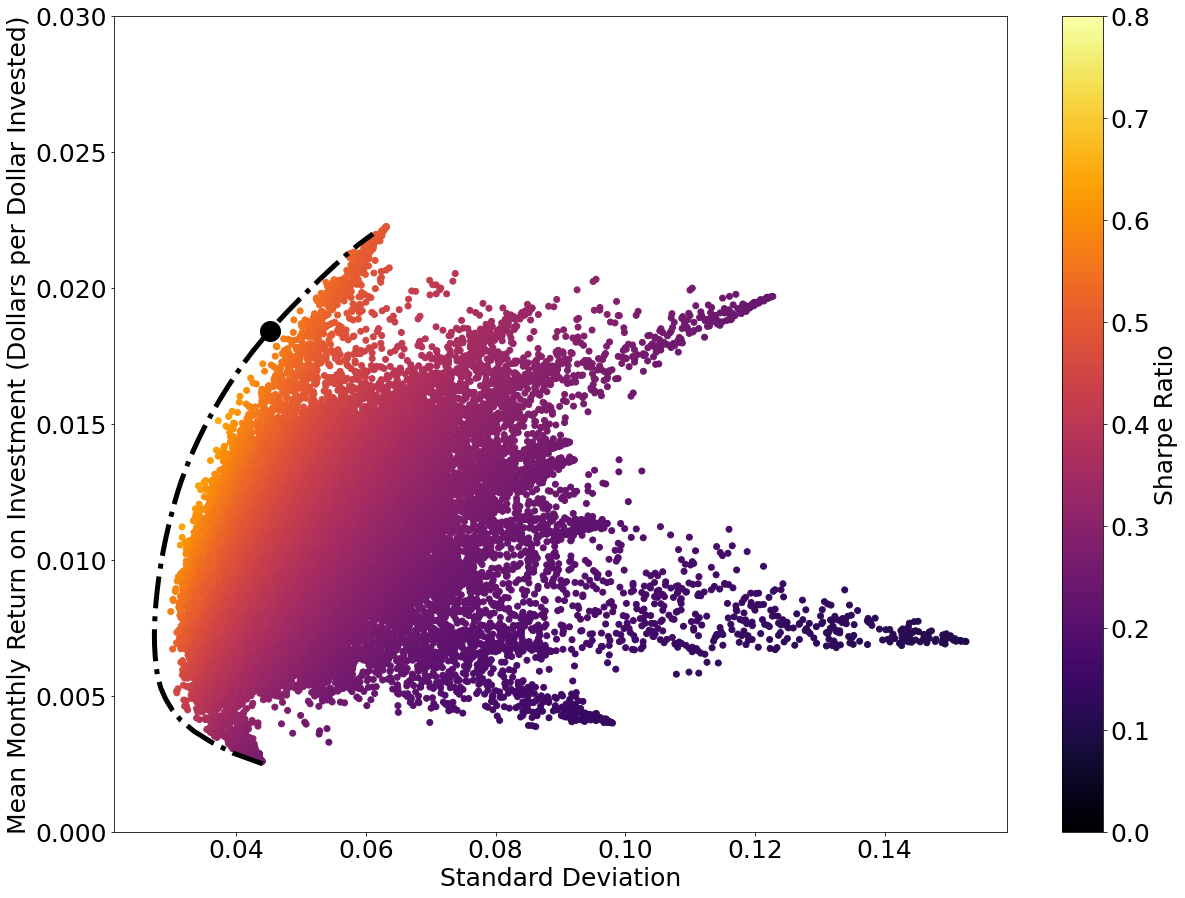

In [19]:
plt.figure(figsize = (20, 15))
plt.scatter(rand_risks, expected_returns, c = sharpe_ratio, cmap = 'inferno', marker= 'o')
plt.plot([p['fun'] for p in efficients], np.linspace(0.0025,0.022, 50), linestyle='-.', linewidth = 5, color='black', label='efficient frontier')
plt.plot(np.sqrt(np.matmul(np.matmul(efficients[index_max_sharpe].x, covariance_returns),efficients[index_max_sharpe].x.T)), np.dot(mean_returns, efficients[index_max_sharpe].x),
        marker = 'o', color = 'black', markersize = 20)
plt.ylim(0,0.03)
plt.clim(0, 0.8)
plt.xlabel("Standard Deviation")
plt.ylabel("Mean Monthly Return on Investment (Dollars per Dollar Invested)")
plt.colorbar(label = "Sharpe Ratio")
plt.rc('font', size = 25)
plt.savefig("ESG50wosharpe.png", dpi = 600)
plt.show()

In [21]:
print(efficients[index_max_sharpe].x)

[0.00000000e+00 3.52193643e-02 0.00000000e+00 1.37768938e-17
 7.77225711e-02 9.66757475e-19 9.10855738e-03 1.32838805e-18
 0.00000000e+00 3.01158585e-18 1.17944684e-17 4.91664070e-18
 0.00000000e+00 1.22880262e-01 6.57333250e-18 0.00000000e+00
 1.25496050e-17 0.00000000e+00 9.22027442e-18 0.00000000e+00
 1.51327727e-18 0.00000000e+00 8.10981318e-18 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.78265198e-01 1.74219877e-18
 5.44578578e-01 0.00000000e+00 2.20482592e-18 3.22254686e-02]


In [20]:
np.savetxt("optimal_ESGweights.csv", efficients[index_max_sharpe].x, delimiter=",")

In [24]:
print(np.sqrt(np.matmul(np.matmul(efficients[index_max_sharpe].x, covariance_returns),efficients[index_max_sharpe].x.T))*np.sqrt(12))
print(np.dot(mean_returns, efficients[index_max_sharpe].x)*12)
print(max(efficient_sharpe_ratios))

0.15624439048255848
0.22102040816054253
0.6933348455850183
